# Check out Pb fields from test runs

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import gsw
import pickle
import pandas as pd
import matplotlib

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

land_color  = '#a9a7a2'

#### Load files:

In [9]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

In [14]:
year=2002

# --- model runs ---
# folder1 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-202211-IC-2002-spin2/'
# folder2 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-202211-IC-2002-spin3/'
folder1 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-2002-kscav-1e-5-biomass-nonlinear-2-3/'
folder2 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-2002-kscav-5e-5-biomass-nonlinear-2-3/'
file1   = xr.open_dataset(f'{folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}10-{year}10.nc')
file2   = xr.open_dataset(f'{folder2}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}10-{year}10.nc')
dpb1    = file1['dissolpb'].values[0,:,:,:]
dpb2    = file2['dissolpb'].values[0,:,:,:]

In [5]:
np.amax(dpb2-dpb1)

1.7093115e-12

In [15]:
# --- GEOTRACES observations: ---
GTR       = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_cruises   = GTR['metavar1']
GTR_lons      = GTR['longitude'].values              # degrees east
GTR_lats      = GTR['latitude'].values               # degrees north
GTR_pres      = GTR['var1'].values                   # Pressure from CTD sensor [dbar]
GTR_depths    = GTR['var2'].values                   # Depth below sea surface calculated from pressure [m]
GTR_temp      = GTR['var3'].values                   # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal       = GTR['var4'].values                   # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_names     = GTR['metavar2'].astype('str').values # Station names

# --- Dissolved Pb concentrations: ---
GTR_qc         = GTR['var16_qc'].values # flag = 51, 52 are probably bad and bad 
GTR_dPb_pmolkg = GTR['var16'].values
GTR_dPb_pmolkg[(GTR_qc == 51) | (GTR_qc == 52)] = np.nan # exclude quality control flagged values

# --- Convert pmol / kg to pmol / L --- (pmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_pressure  = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs   = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density   = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3
GTR_dPb_pmolL = GTR_dPb_pmolkg*GTR_density*1e-3
GTR_dPb_pmolL[GTR_dPb_pmolL < 0] = np.nan # can't have negative concentrations

#### Figure:

In [11]:
def plot_layer(variable, layers, vmin=0, vmax=30, cmap1=cmocean.cm.thermal, obs=False):
    
    fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb6.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    
    for n, axis in enumerate(ax.ravel()):

        CB = axis.pcolormesh(x, y, variable[layers[n],:,:]*1e12, cmap=cmap1, vmin=vmin, vmax=vmax) 
        axis.contourf(x, y, bathy_masked[layers[n],imin:imax,jmin:jmax], colors=[land_color], zorder=2) # Mask land at particular depth
        axis.set_title(f'Depth: {mesh_depth[layers[n]]:.1f} m', fontsize=6)
        
        if obs: #plot circles with 2015 GEOTRACES observations
            GTR_lons_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                             (GTR_lats < 65) & (GTR_lons > 300) | \
                                             (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lons)
            GTR_lats_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                             (GTR_lats < 65) & (GTR_lons > 300) | \
                                             (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lats)
            x_GTR, y_GTR = proj1(GTR_lons_ma, GTR_lats_ma)

            # filter based on depth:
            if mesh_depth[layers[n]] < 200: # in shallow areas use only observations that are within 15 m from layer
                depth_mask     = (GTR_depths > mesh_depth[layers[n]] - 15) & (GTR_depths < mesh_depth[layers[n]] + 15)
            else:  # in deeper waters use observations that are within 50 m from the layer
                depth_mask     = (GTR_depths > mesh_depth[layers[n]] - 50) & (GTR_depths < mesh_depth[layers[n]] + 50)
            GTR_dPb_masked = np.ma.masked_where(~depth_mask, GTR_dPb_pmolL) # calculate mean over observations within this range
            GTR_dPb_slice  = np.nanmean(GTR_dPb_masked, axis=1)
            axis.scatter(x_GTR, y_GTR, c=GTR_dPb_slice, \
                         s=50, zorder=3, edgecolor='w', marker='.', 
                         linewidth=0.5, vmin=vmin, vmax=vmax, cmap=cmap1, label='2015 GEOTRACES GN02, GN03')

#     Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.03, 0.55, 0.02, 0.18]);
    CBar   = plt.colorbar(CB, ax=ax[0,0], cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
    
    return

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


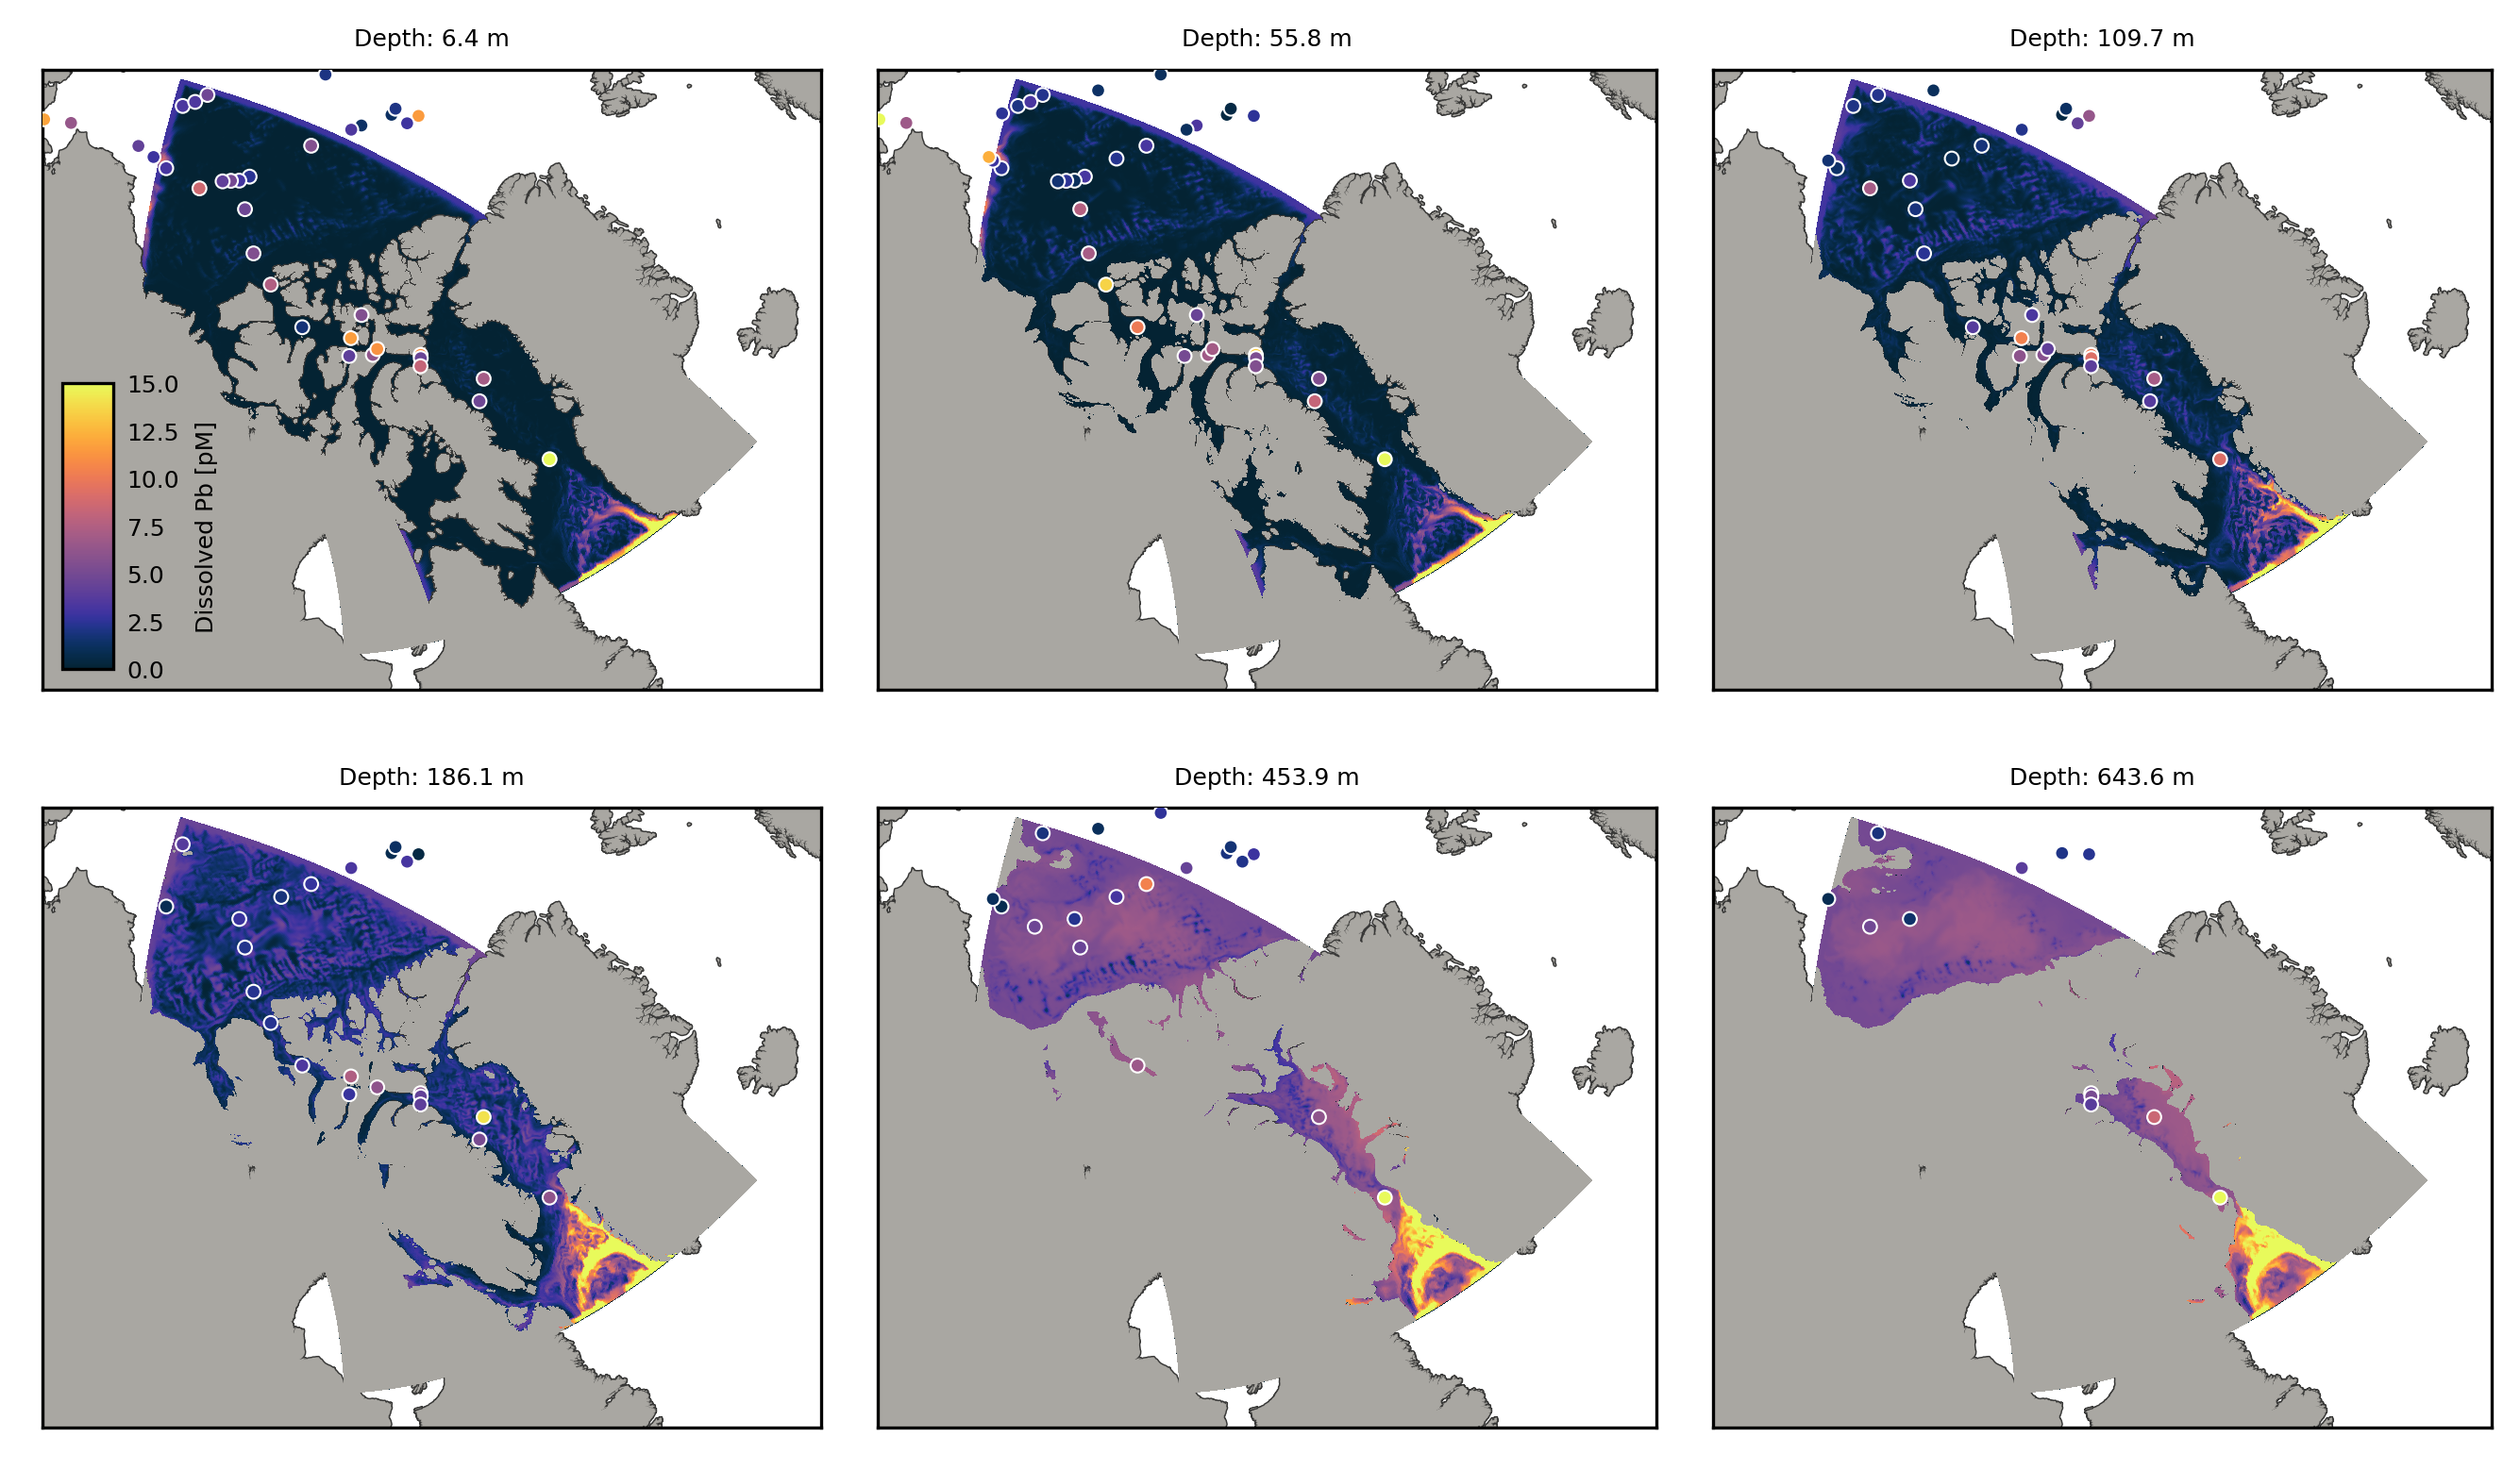

In [13]:
plot_layer(dpb1, (5,18,22,25,30,32), vmin=0, vmax=15, cmap1=cmocean.cm.thermal, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


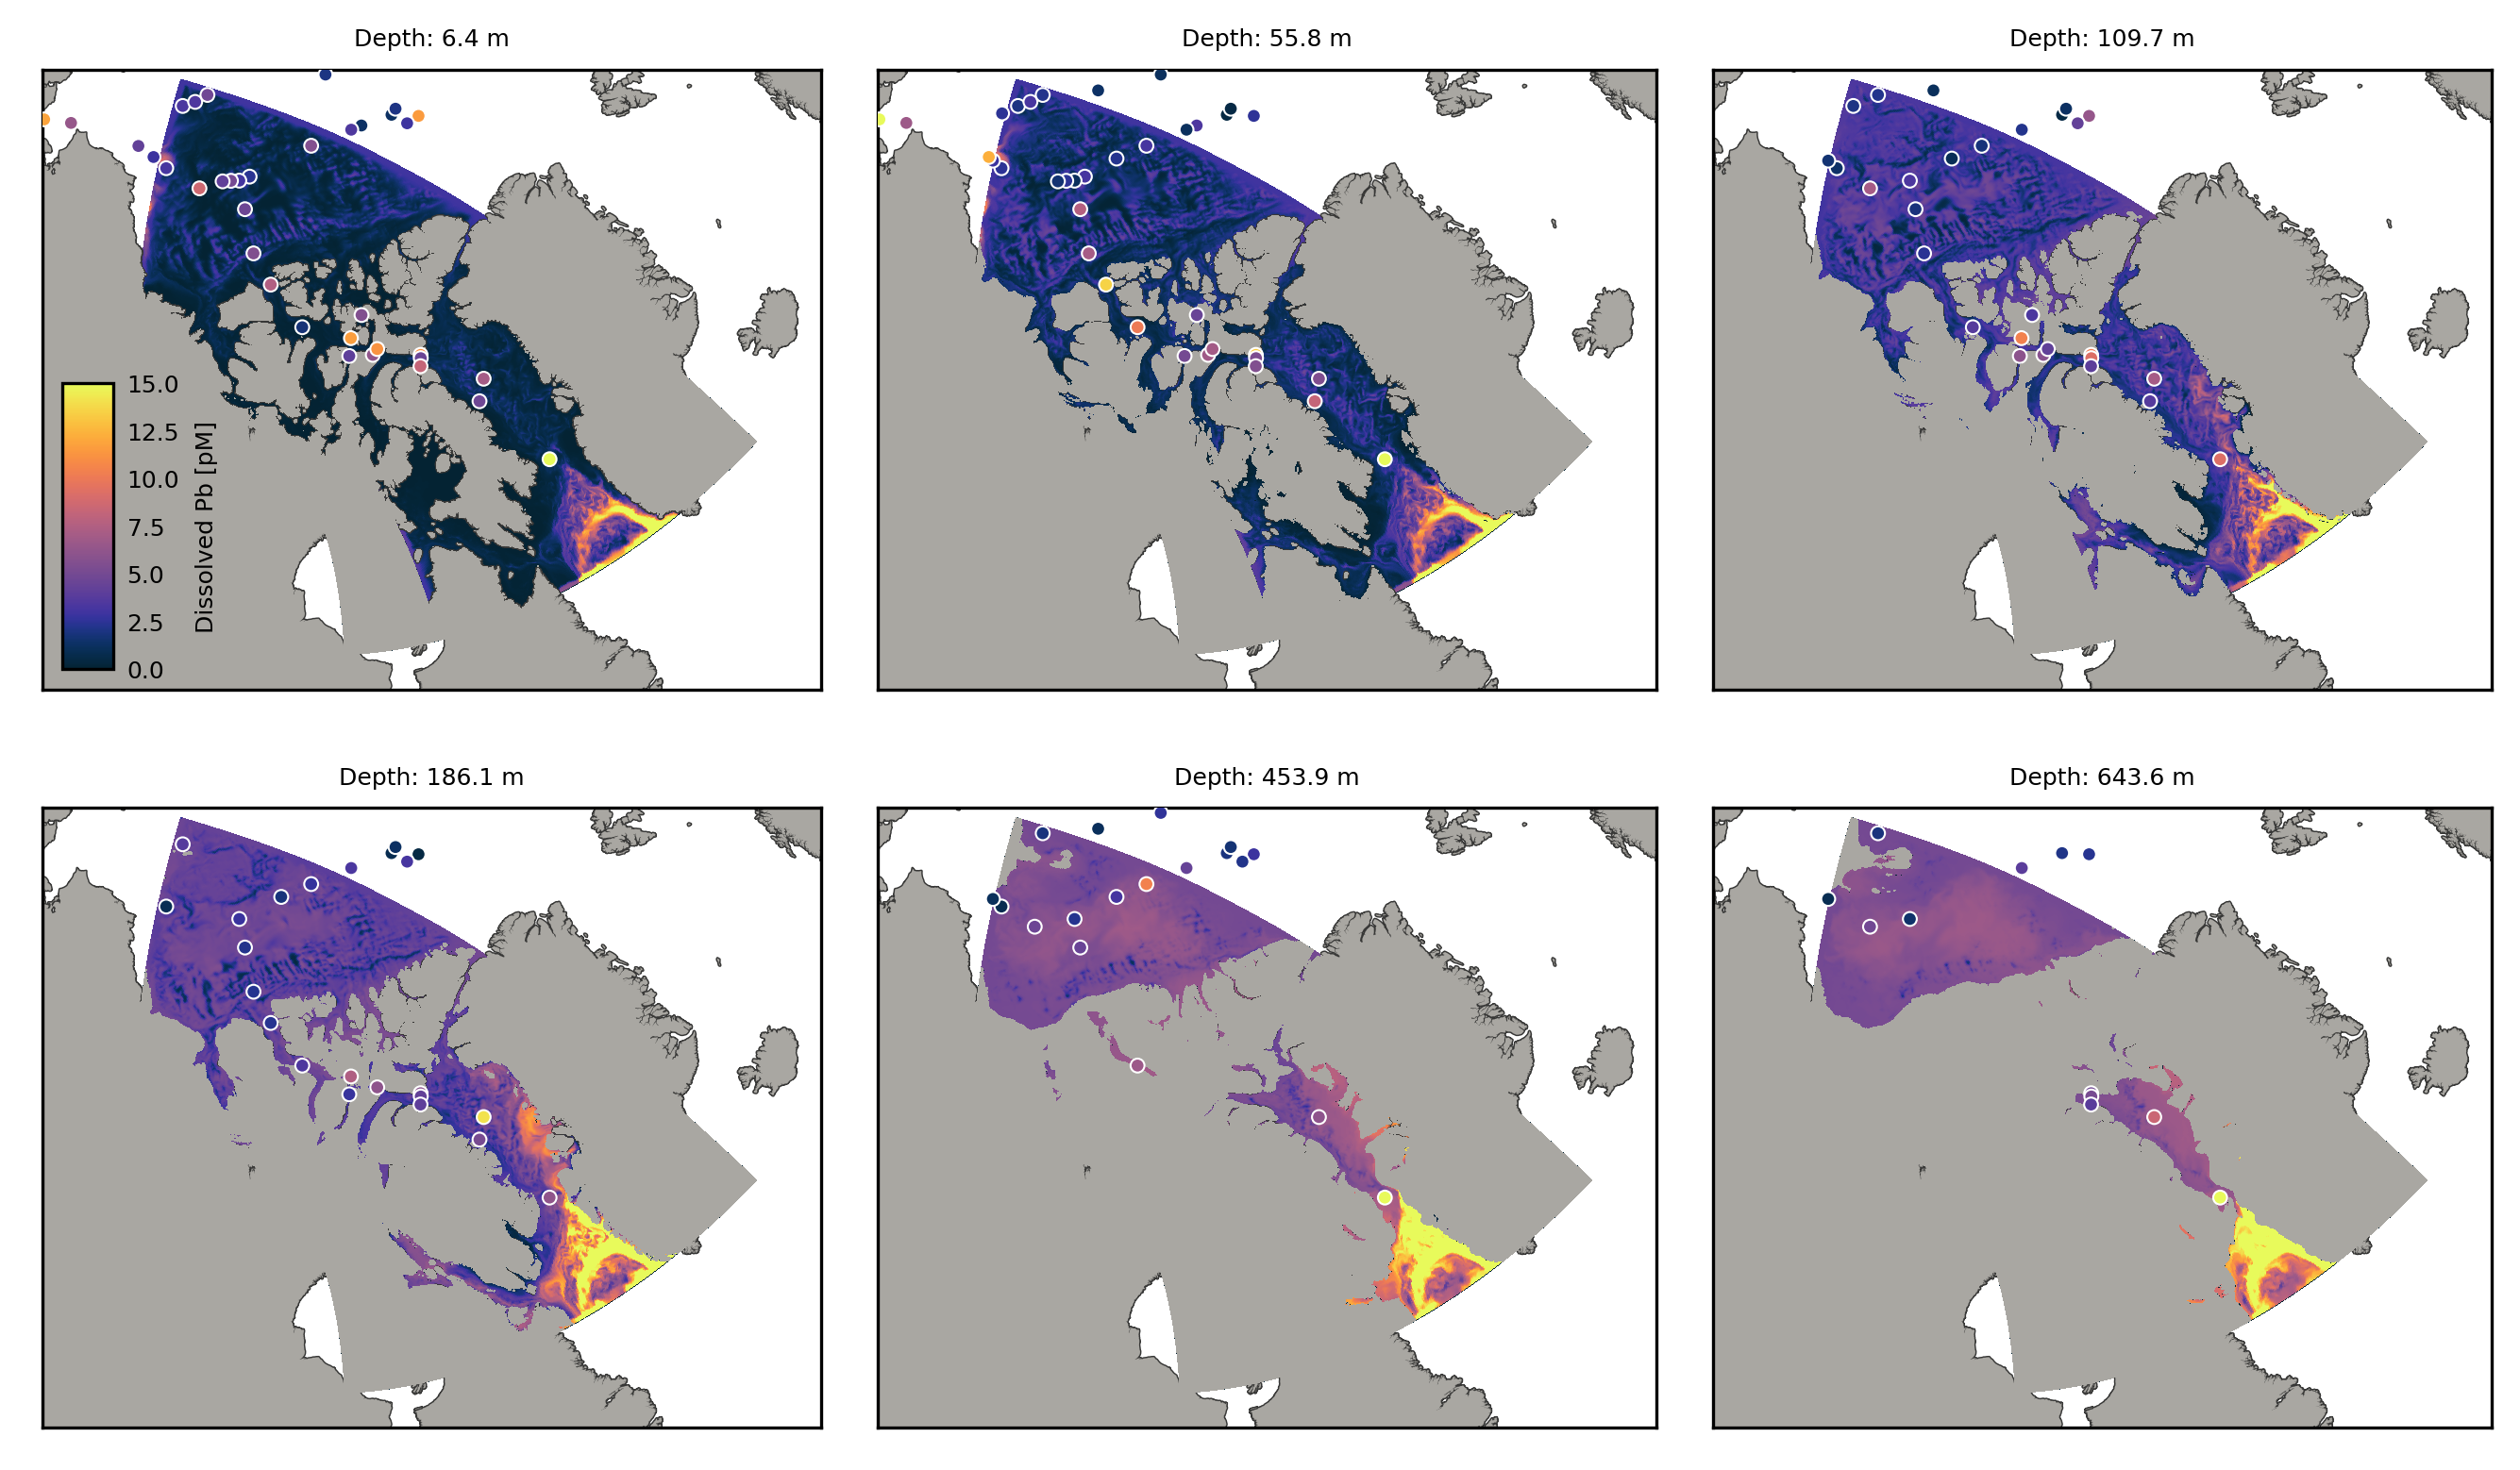

In [12]:
plot_layer(dpb2, (5,18,22,25,30,32), vmin=0, vmax=15, cmap1=cmocean.cm.thermal, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


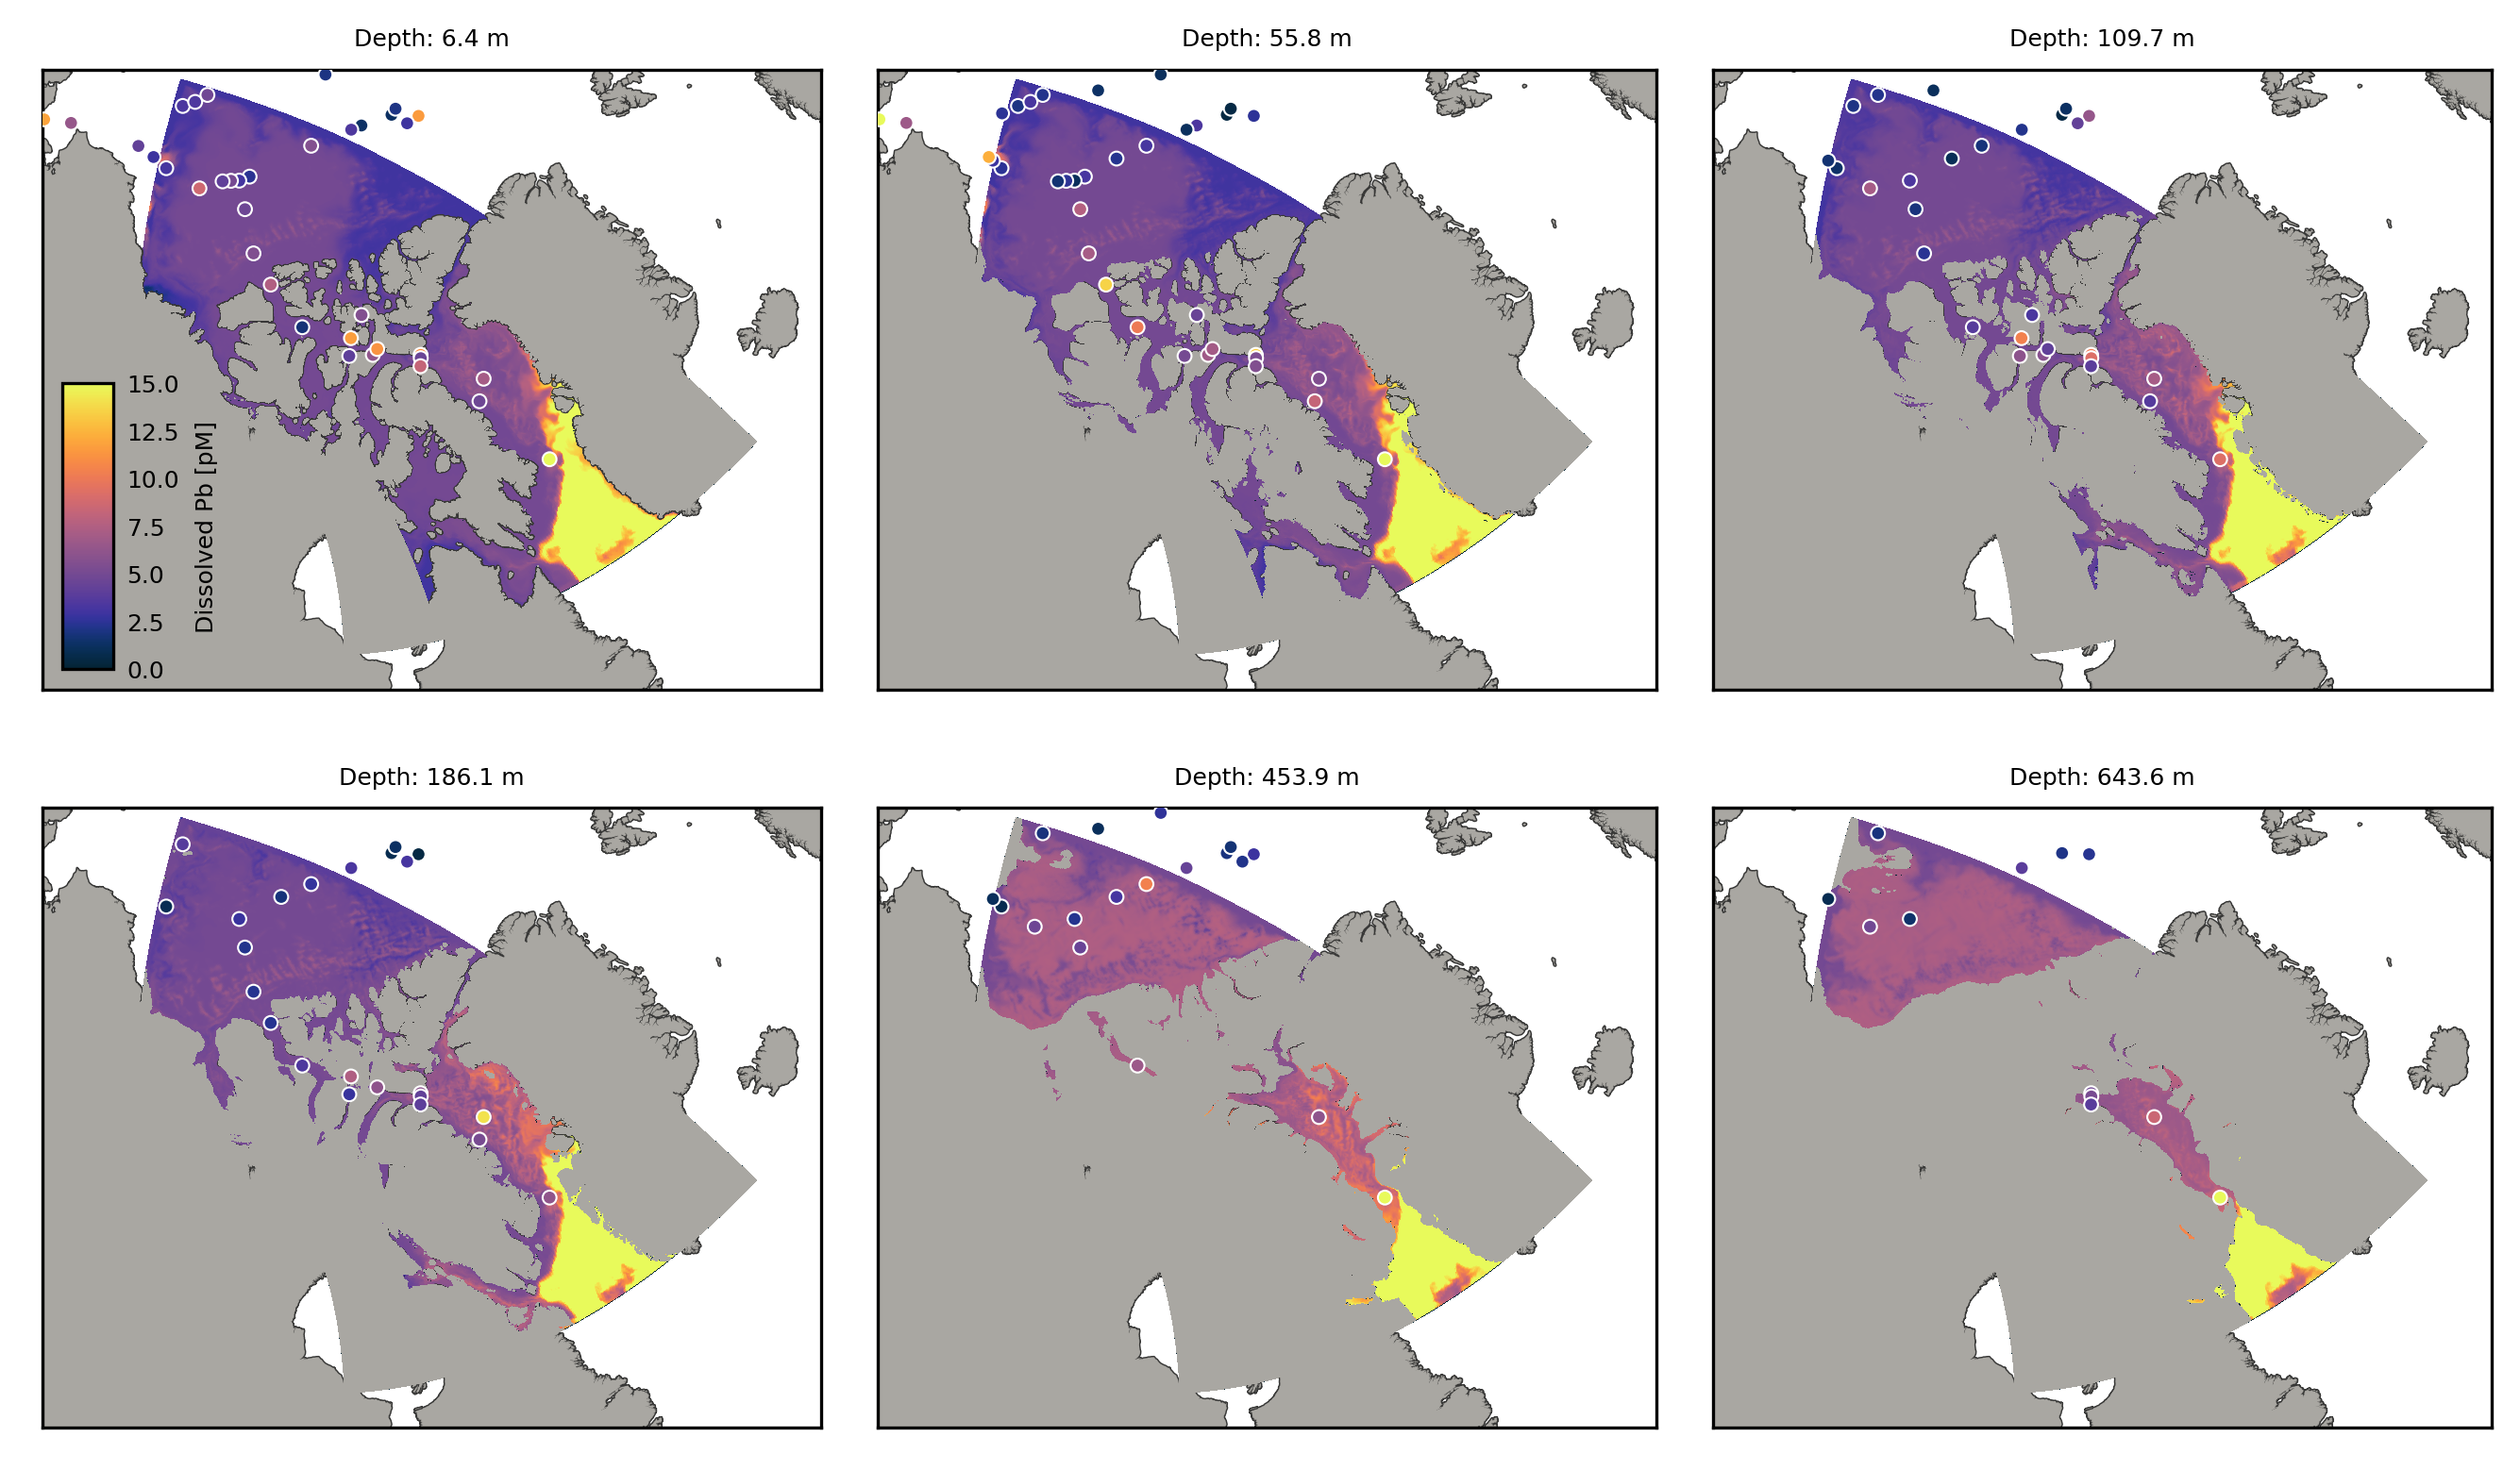

In [13]:
plot_layer(dpb1, (5,18,22,25,30,32), vmin=0, vmax=15, cmap1=cmocean.cm.thermal, obs=True)

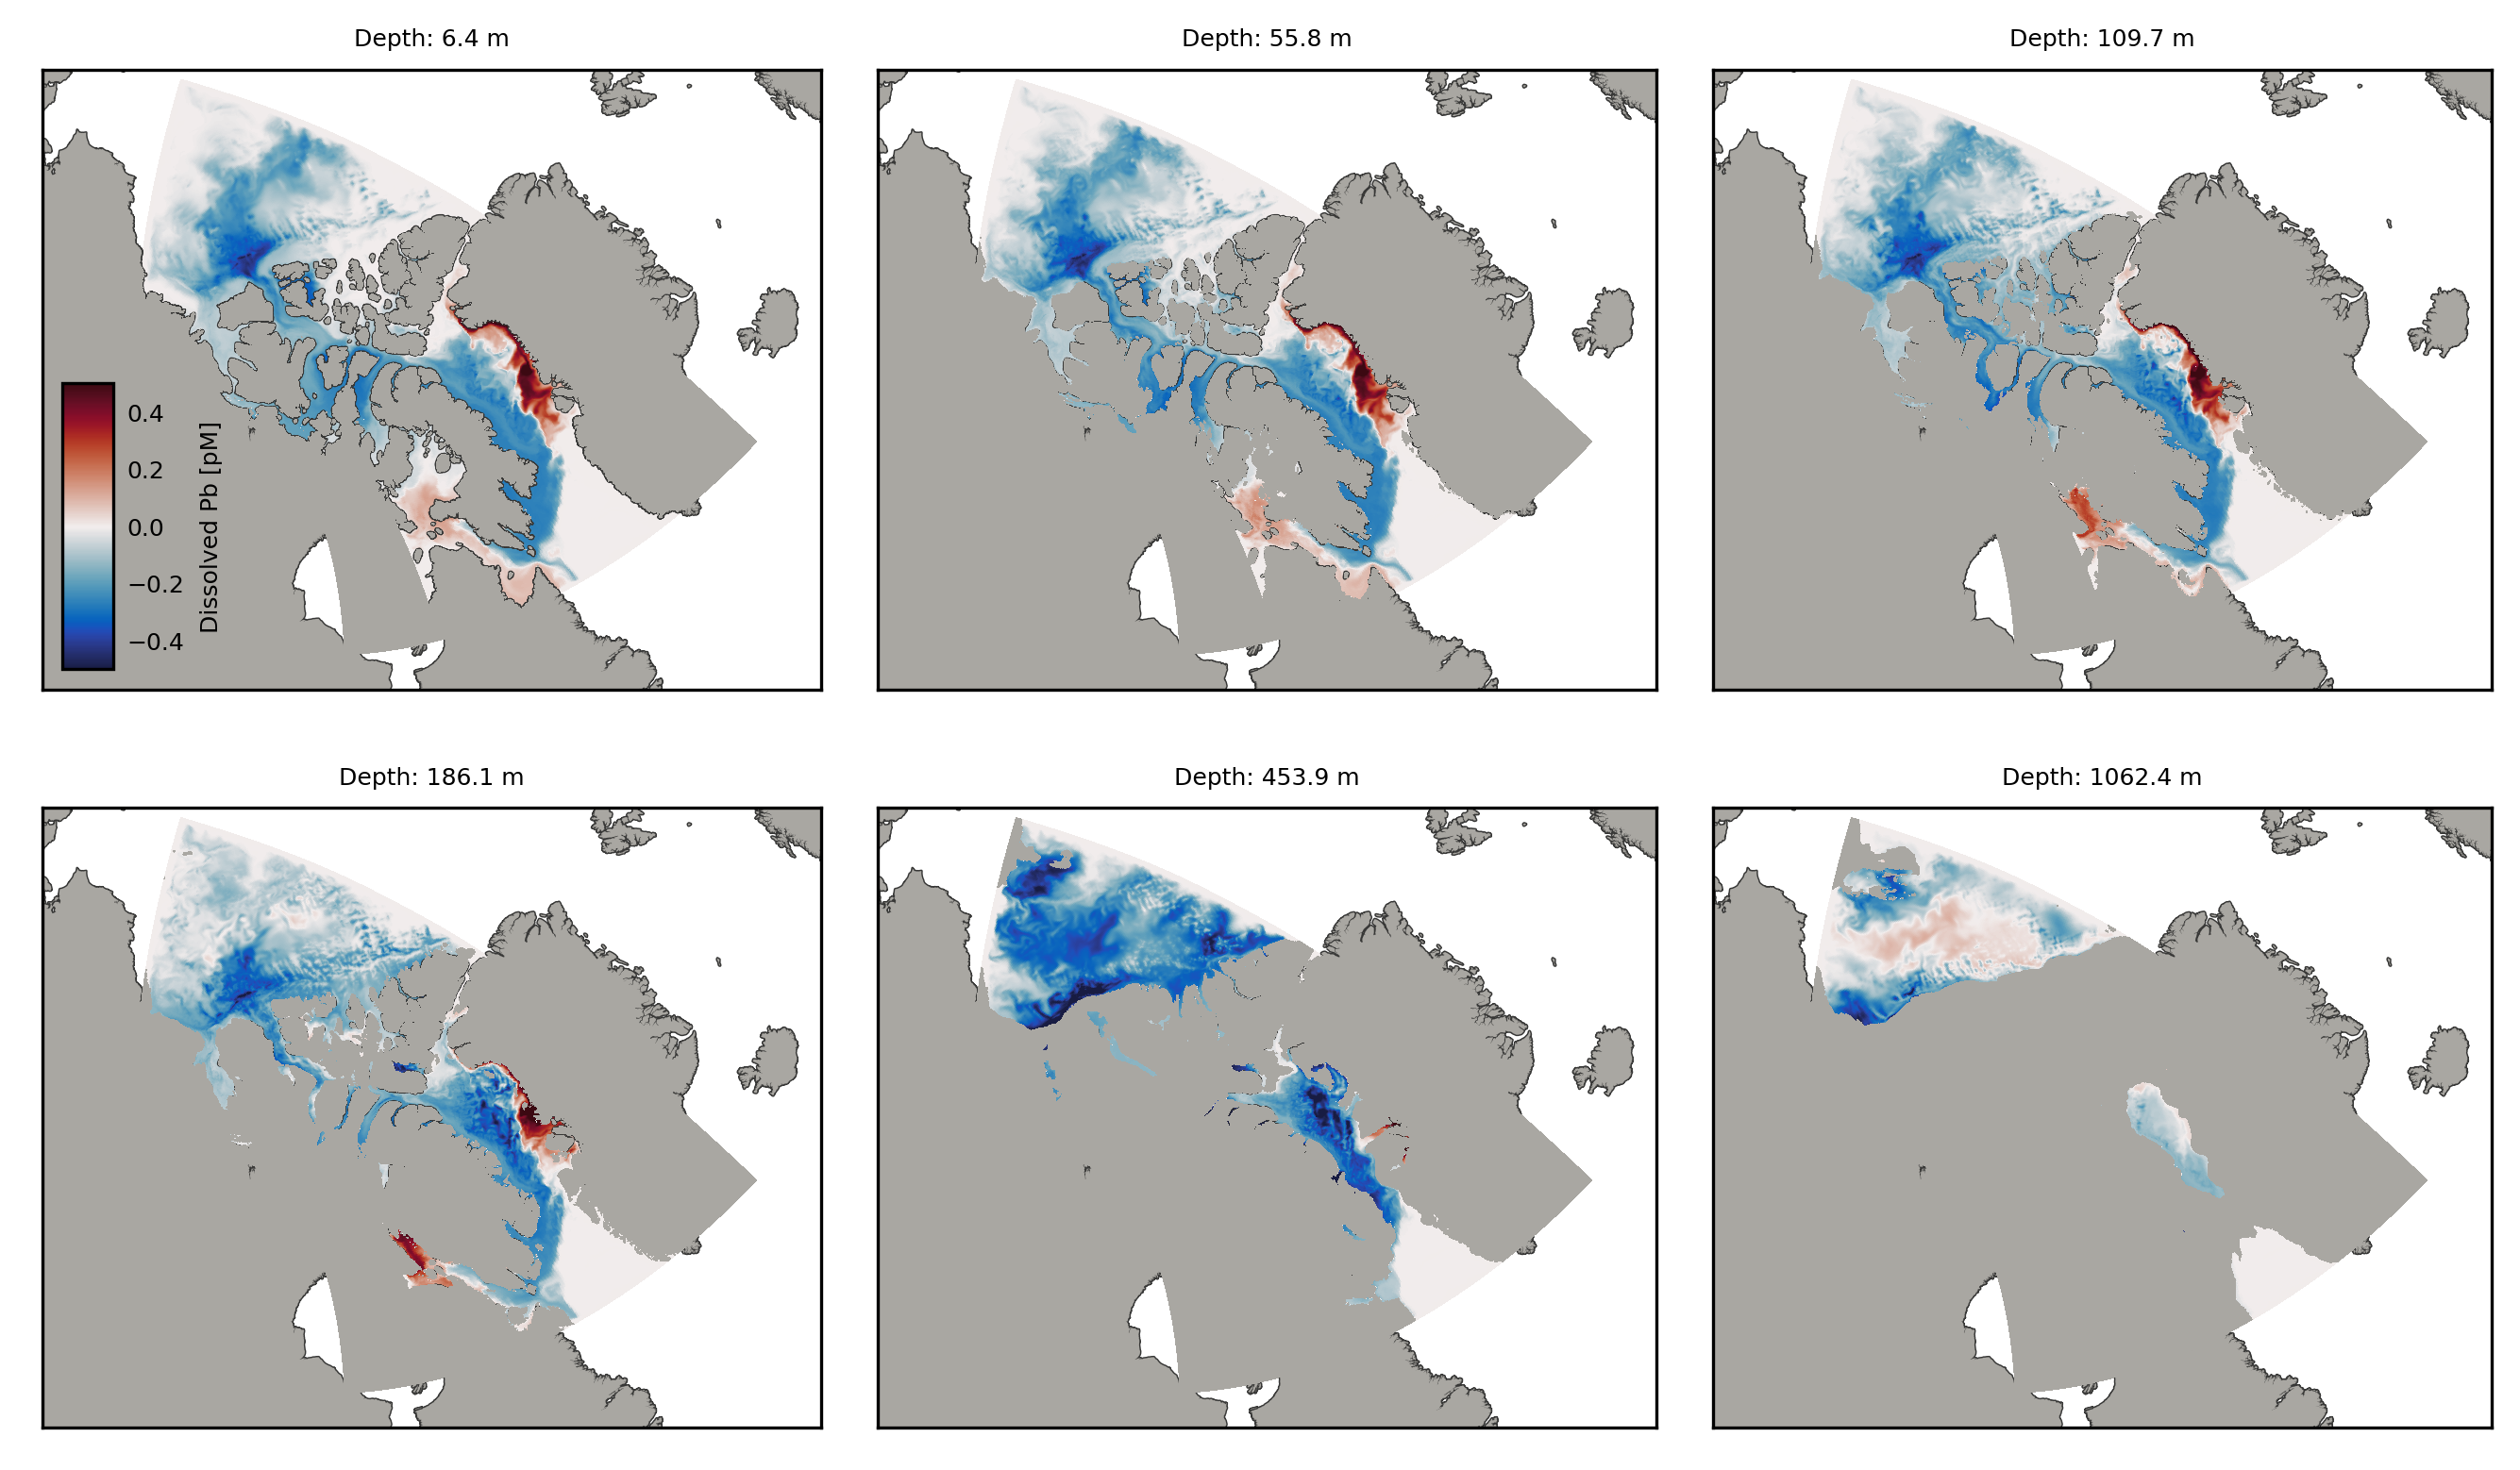

In [9]:
plot_layer(dpb2-dpb1, (5,18,22,25,30,35), vmin=-0.5, vmax=0.5, cmap1=cmocean.cm.balance)

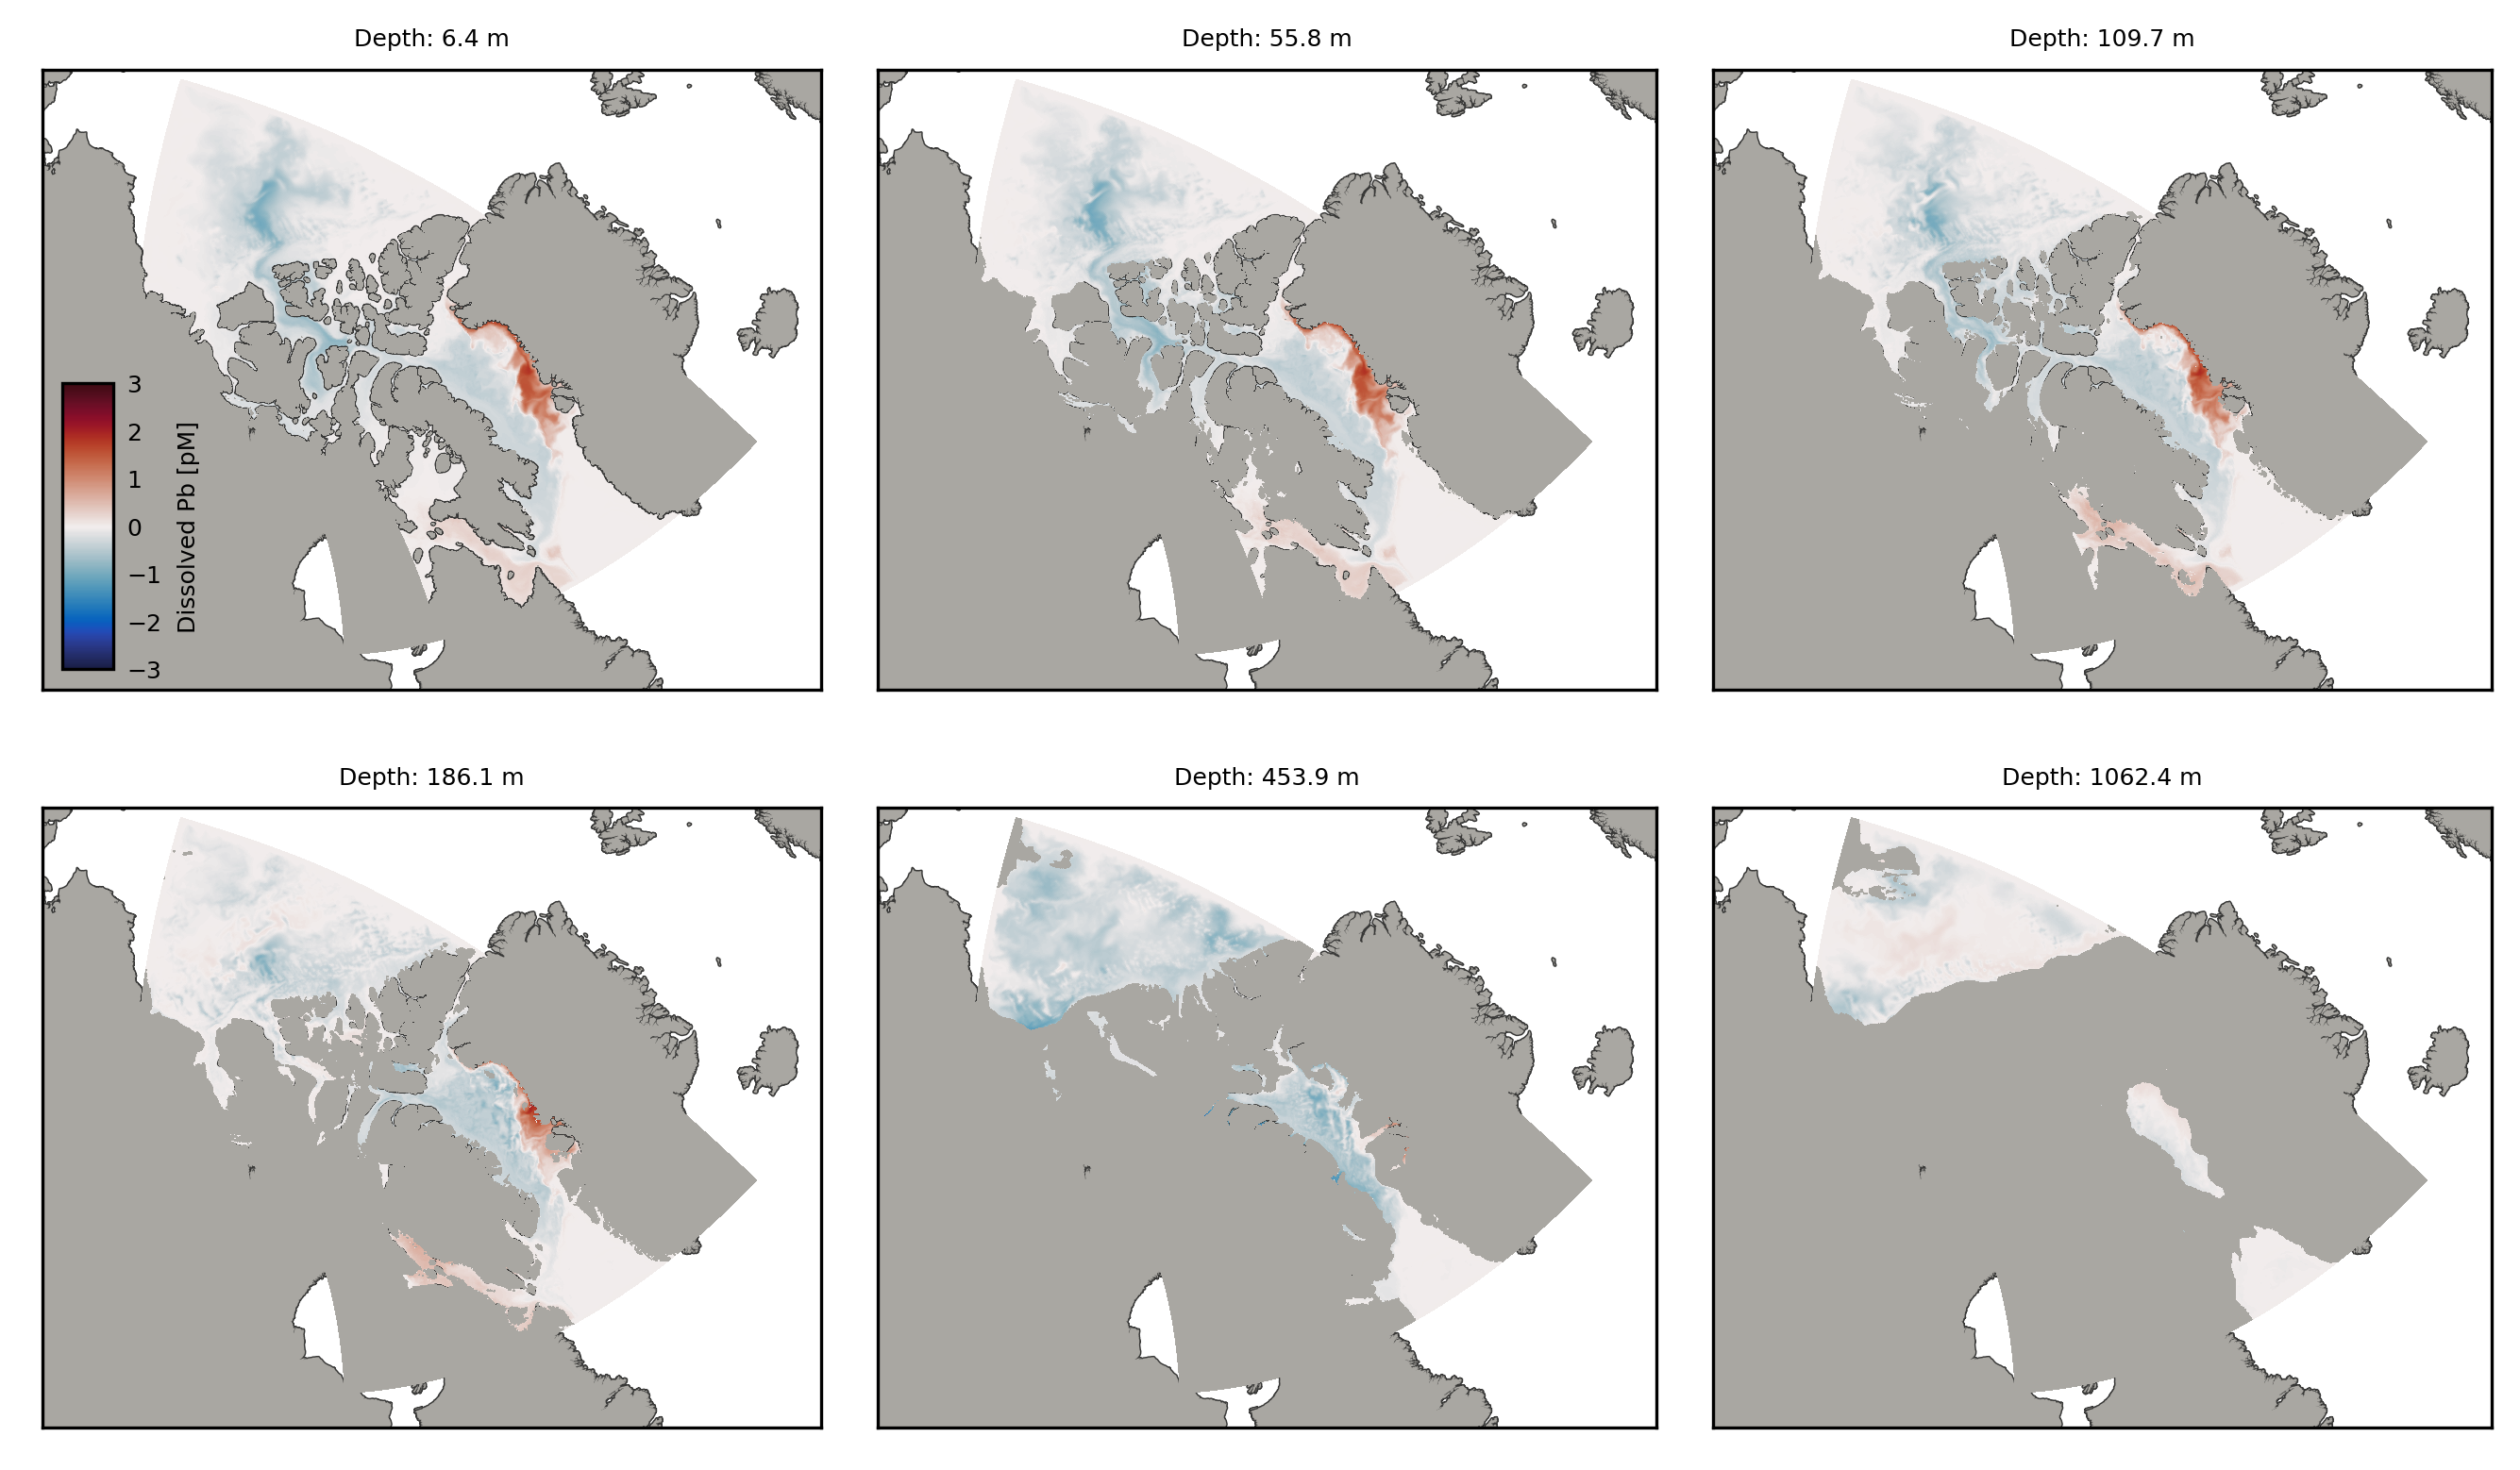

In [19]:
plot_layer(dpb2-dpb1, (5,18,22,25,30,35), vmin=-3, vmax=3, cmap1=cmocean.cm.balance)

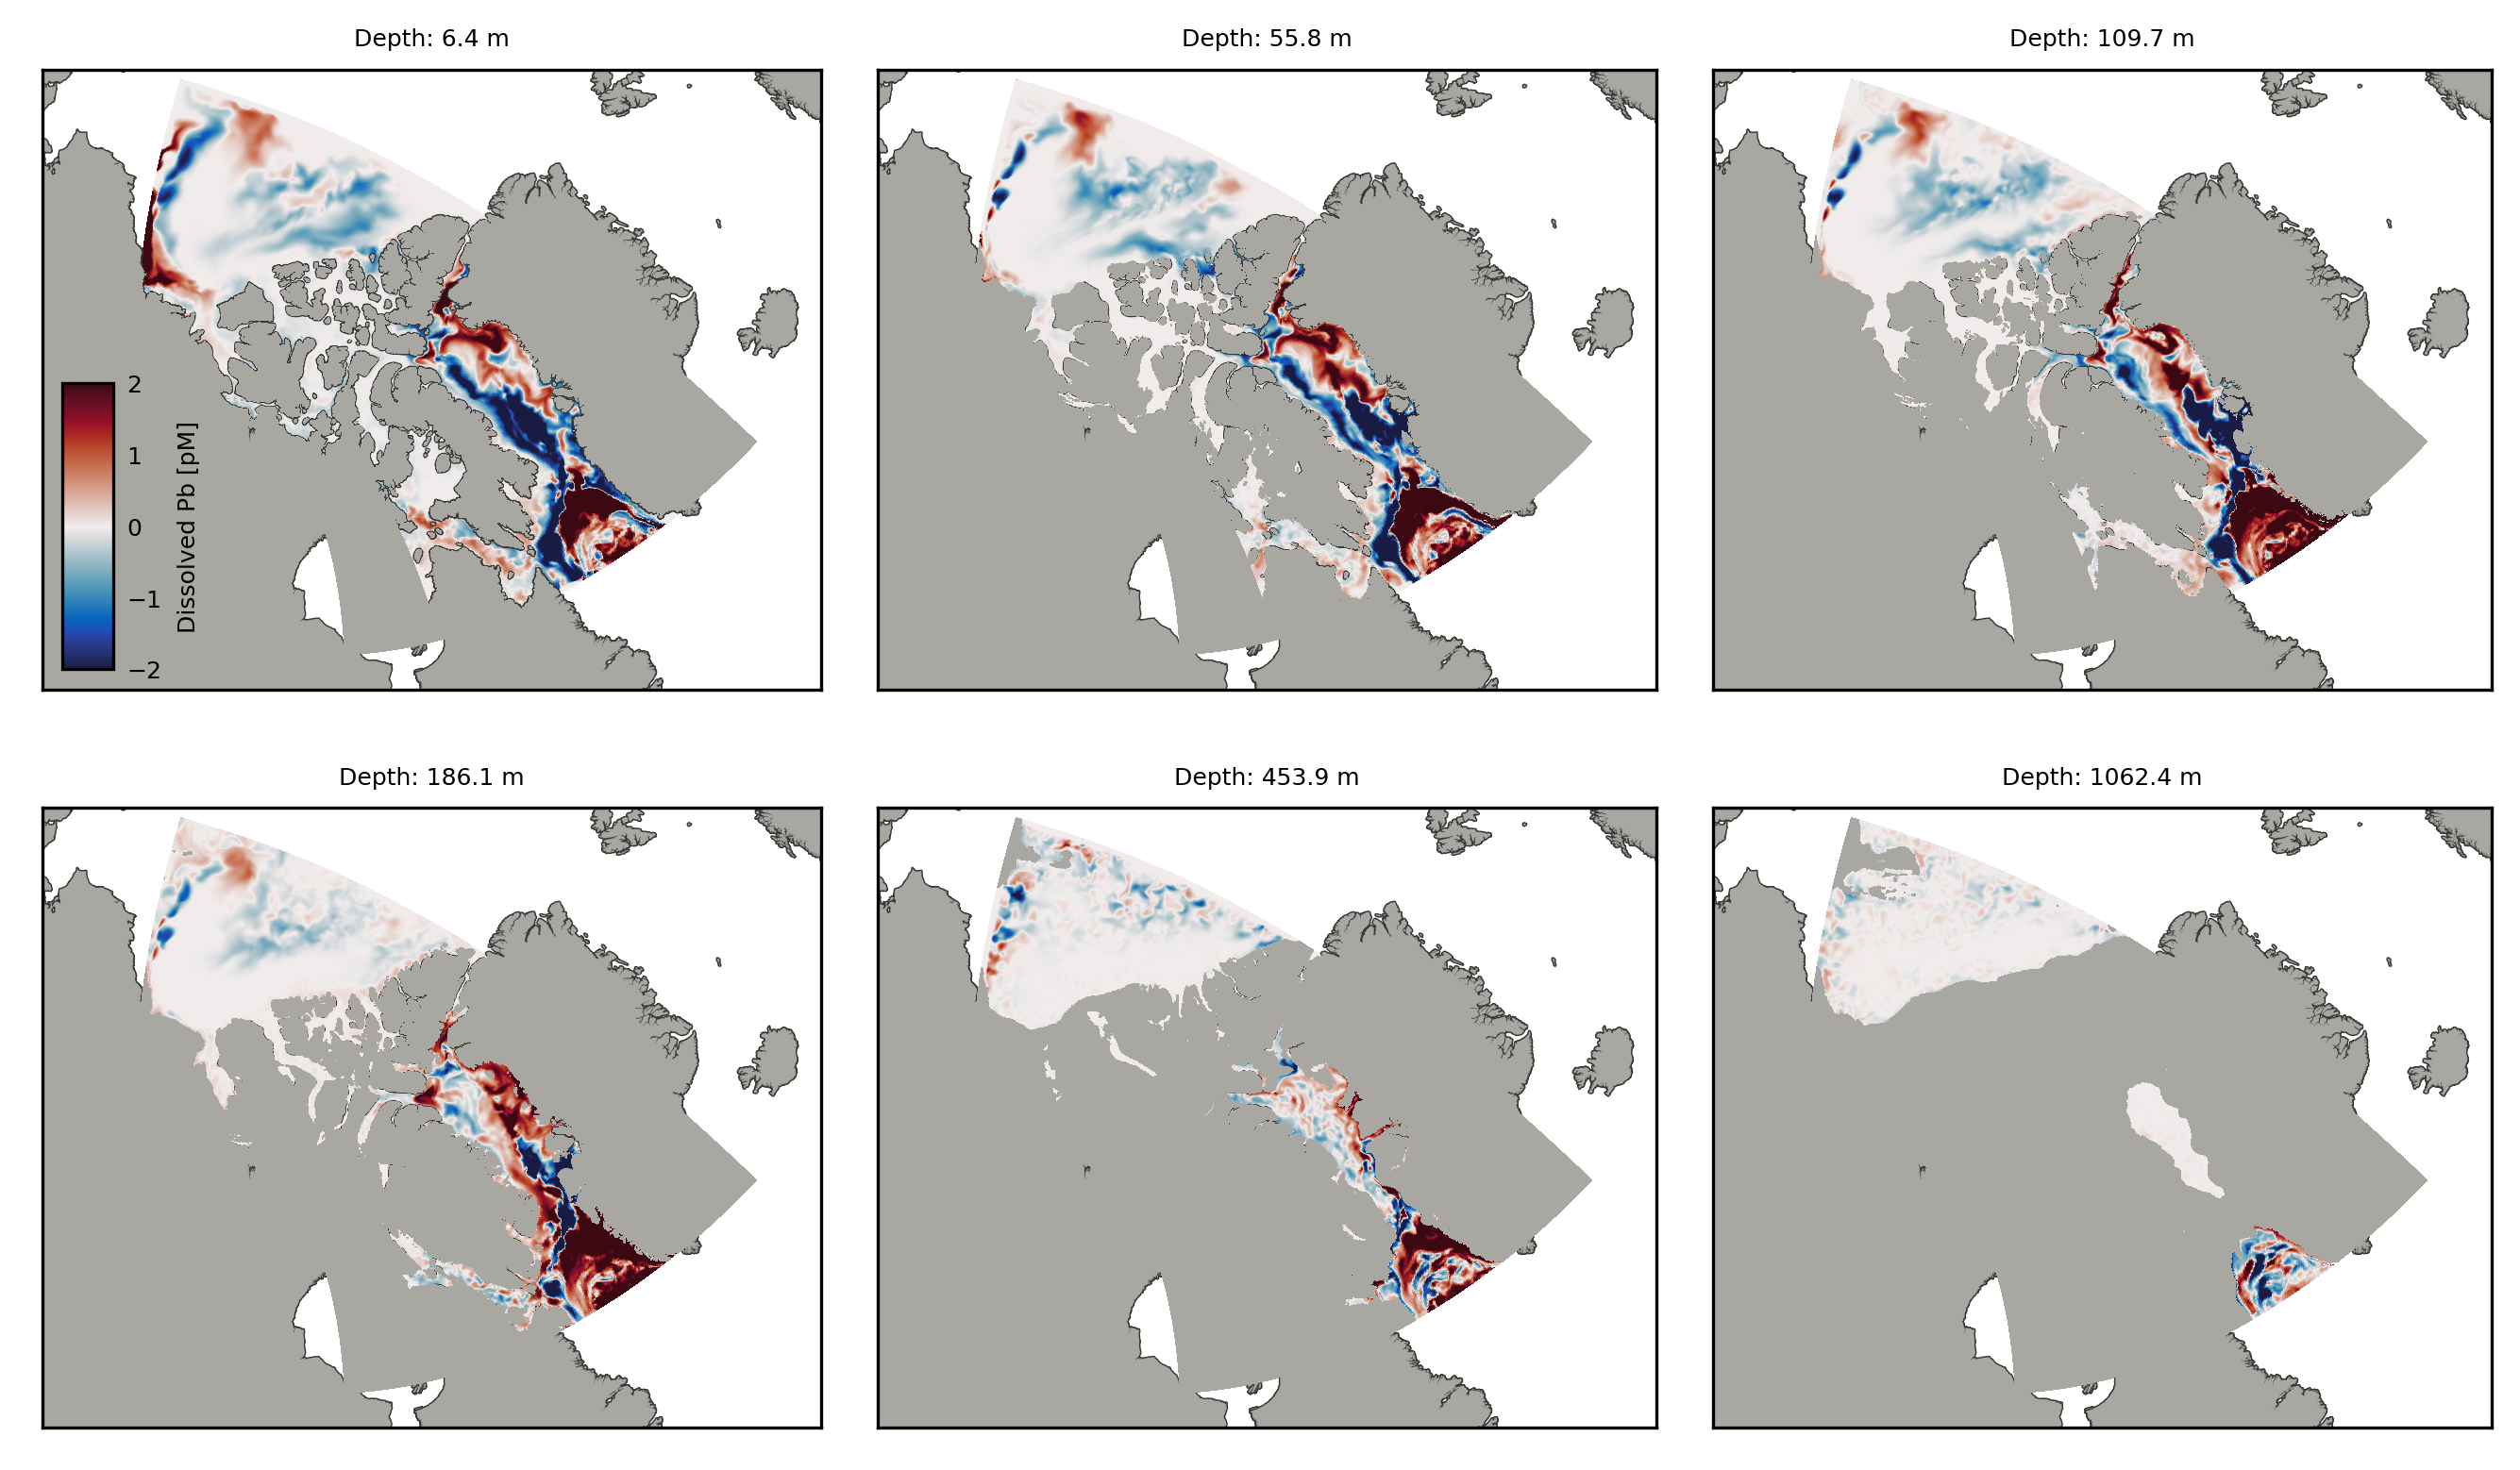

In [43]:
plot_layer(dpb2-dpb1, (5,18,22,25,30,35), vmin=-2, vmax=2, cmap1=cmocean.cm.balance)

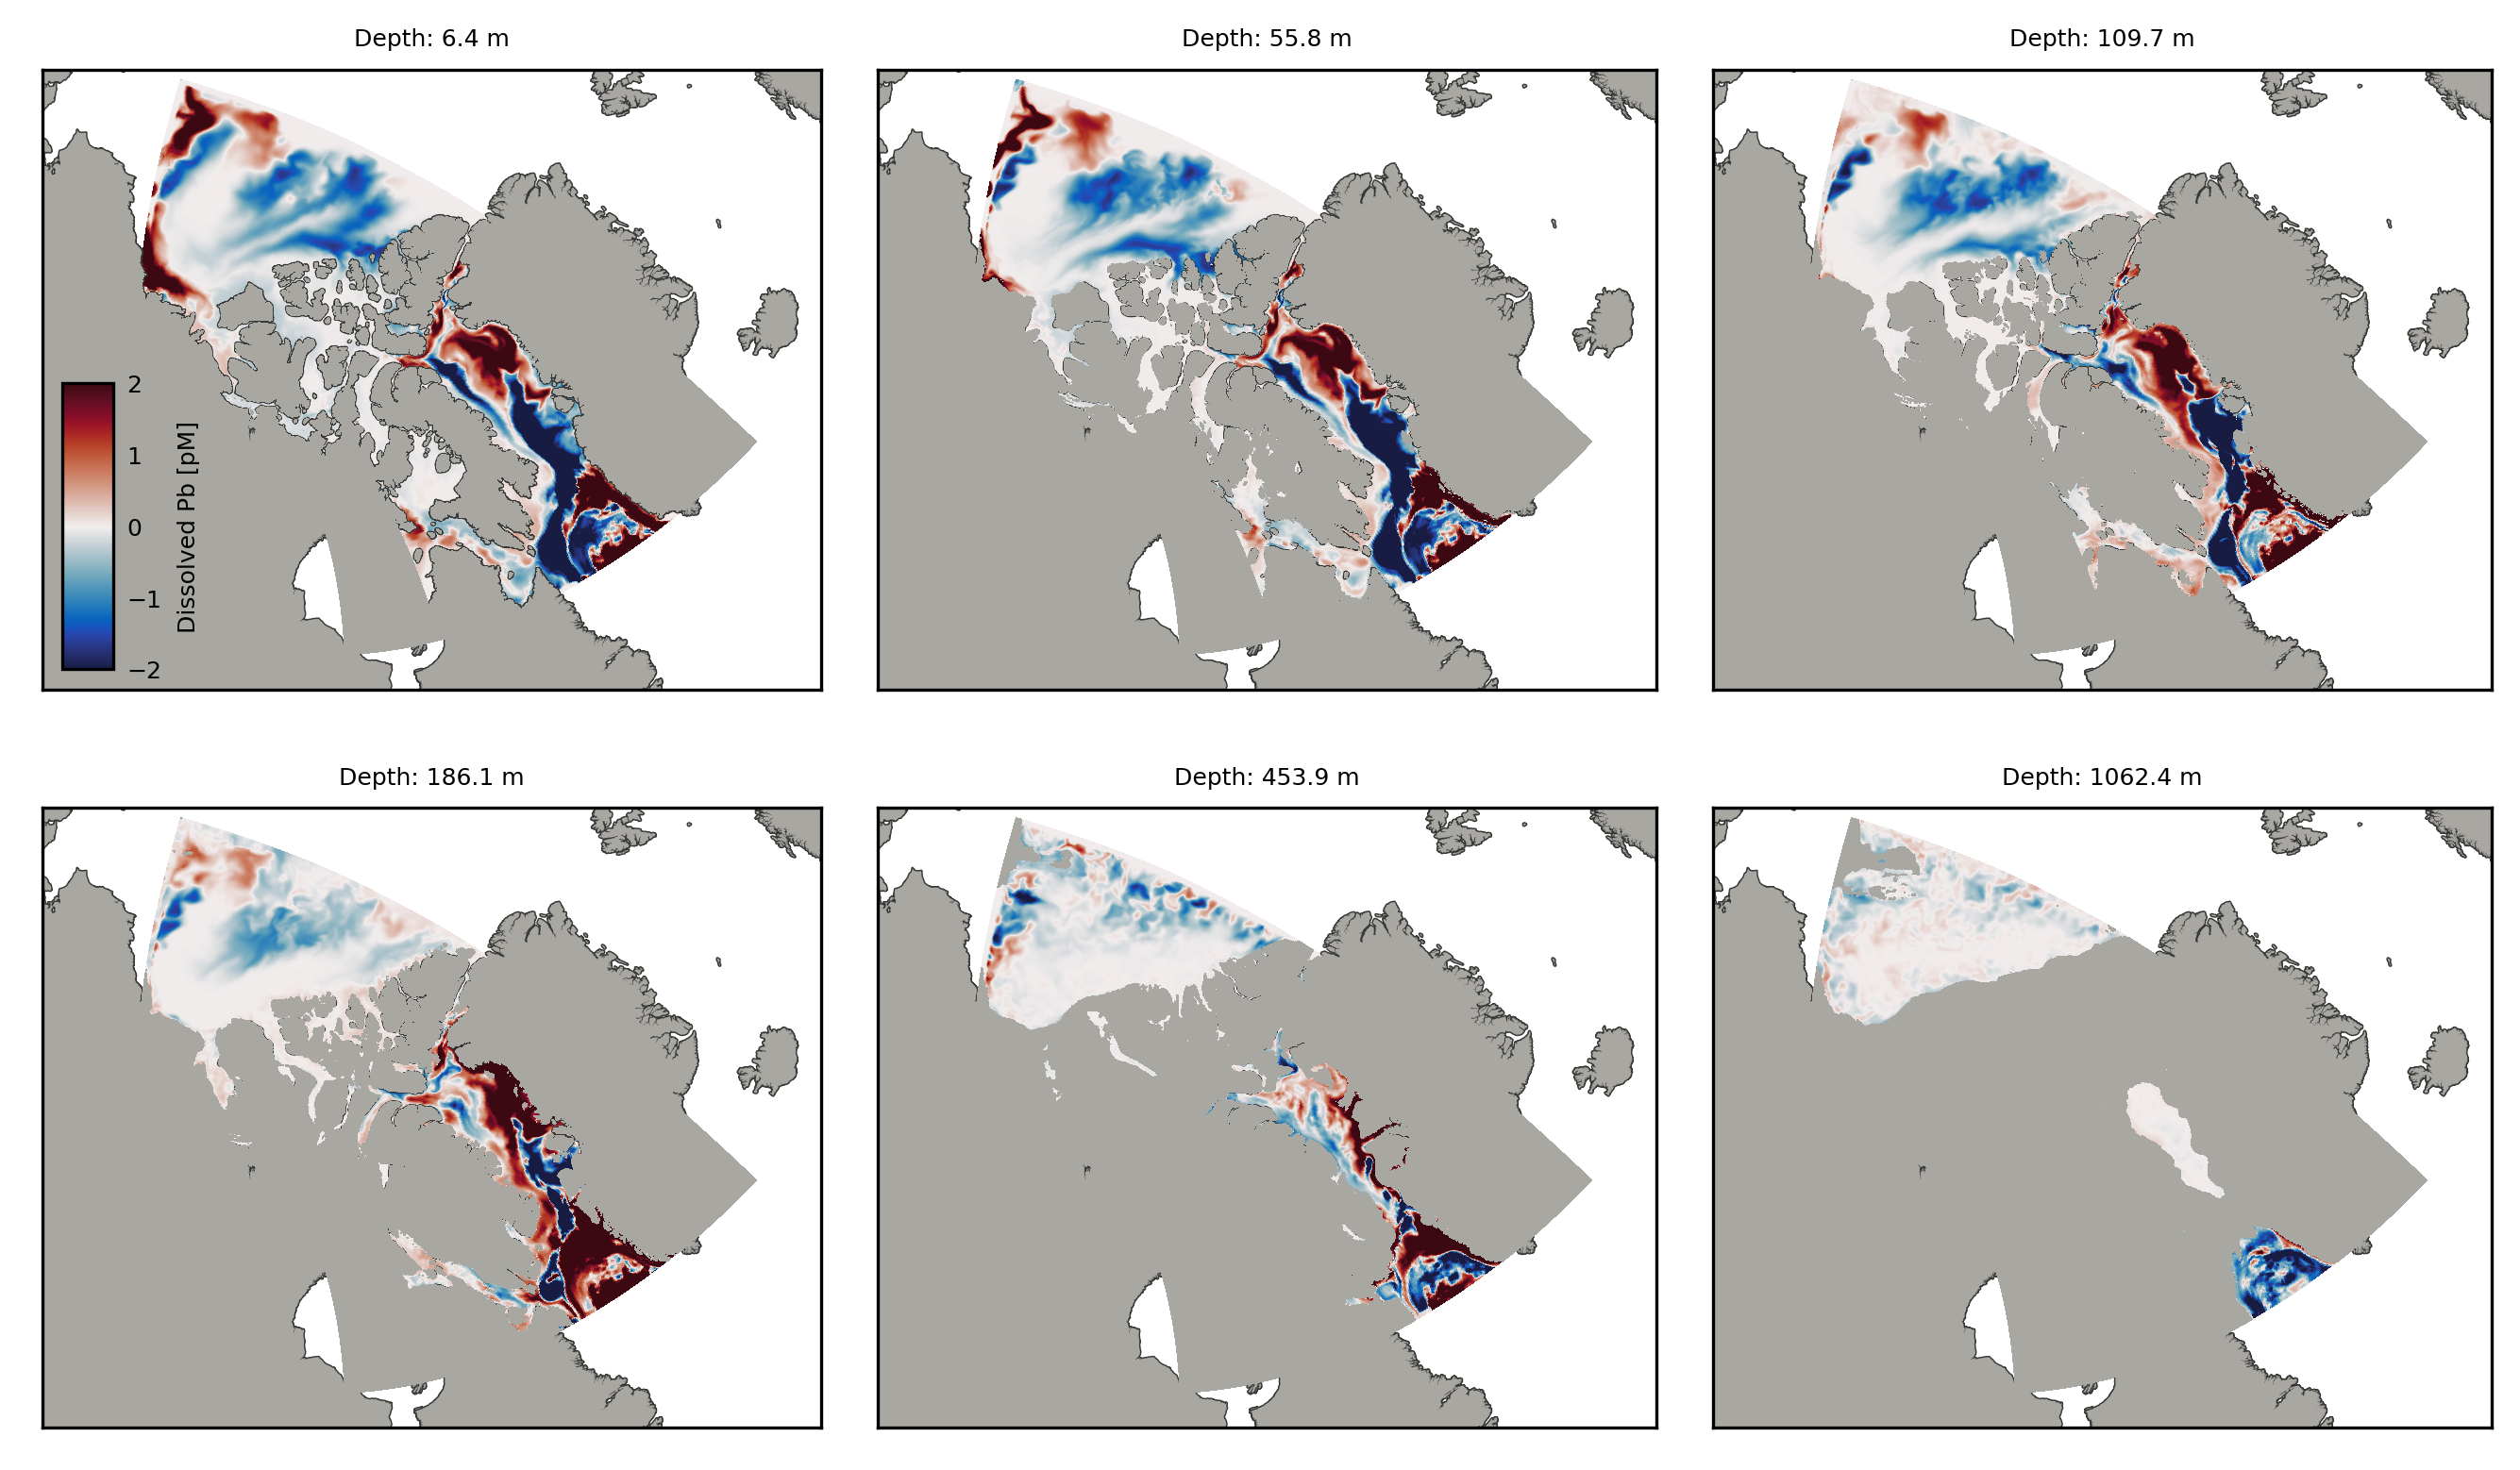

In [45]:
plot_layer(dpb2-dpb1, (5,18,22,25,30,35), vmin=-2, vmax=2, cmap1=cmocean.cm.balance)